In [12]:
from IPython.display import HTML, display
from helper import hide_toggle
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='retina'

from helper import hide_toggle
hide_toggle()

# Understanding the mutation count tensor

Let us start by creating a simulated mutation count tensor to better understand the structure of this data type. The `data` module of tensorsignatures provides a `TensorSignatureData` class which allows us to simulate such data. To do so, we import the package and create a `TensorSignatureData` instance.

In [2]:
import tensorsignatures as ts
data = ts.TensorSignatureData(
    seed=573, # set a seed for reproducibility
    rank=5, # number of signatures
    samples=100, # number of samples
    dimensions=[3, 5], # number of arbitrary genomic dimensions
    mutations=1000)

This command generates data from five signatures (`rank`) to simulate 100 genomes (`samples`) each with 1000 mutations (mutations). By passing the list [3, 5] to the `dimensions` argument, we create two additional genomic dimensions (in addition to the dimensions specifying transcription and replication) with 3 and 5 states respectively. To obtain the SNV count tensor, we invoke the snv method of data, which returns the single base substitution count tensor.

In [3]:
snv = data.snv()

Similarly, we can extract a simulated matrix of other mutation counts by invoking the `other` method.

In [4]:
other = data.other()

## The mutation count tensor is a multidimensional array with a specific structure

The `snv` object is simply a 6-dimensional `numpy` array,

In [5]:
snv.ndim

6

whose `shape` attribute is a tuple of integers indicating the size, i.e. the number of states,
of the array in each dimension.

In [6]:
snv.shape

(3, 3, 3, 5, 96, 100)

TensorSignatures expects the structure of the count tensor to follow a specific convention: the first and second dimension (`snv.shape[0]` and `snv.shape[1]`) split counts by tran- scription and replication strand, following dimensions partition single base substitution by ge- nomic factors, and the penultimate (`snv.shape[-2]`) and last dimension (`snv.shape[-1]`) represent substitution types and samples respectively. Table A.1 summarises the structure of the count tensor.

## Extracting the single base substutions from specific genomic states

We index the SNV tensor like any other numpy array. For example, to obtain variants from template and leading strands, and from the “unassigned” state of additional genomic dimensions, we simply index the tensor with `snv[0, 1, 0, 0, :, :]` which returns a two dimensional array with mutation types along the first axis and samples along the other.

In [7]:
slice = snv[0, 1, 0, 0, :, :]
slice.shape

(96, 100)

Note, that we can reconstruct the $p \times n$ mutation count matrix, which usually serves as an input for conventional mutational signature analysis, by summing over all dimensions except the last two (representing single base substitution types and samples respectively). The following code illustrates this operation.

In [8]:
collapsed = snv.sum(axis=(0,1,2,3,))
collapsed.shape

(96, 100)

Another useful technique is to first index a specific state, and then to sum over all other dimensions to exclude. This allows us to extract the spectra from specific genomic states, for example, to extract all coding and template strand mutations from the tensor we would simply run

In [9]:
coding = snv[0].sum(axis=(0,1,2,4))
template = snv[1].sum(axis=(0,1,2,4))

of course this also works for any other dimension, for example, leading and lagging strand mutations maybe extracted as follows.

In [10]:
leading = snv[:,0].sum(axis=(0,1,2,4))
lagging = snv[:,1].sum(axis=(0,1,2,4))

To understand how they differ we may plot them,

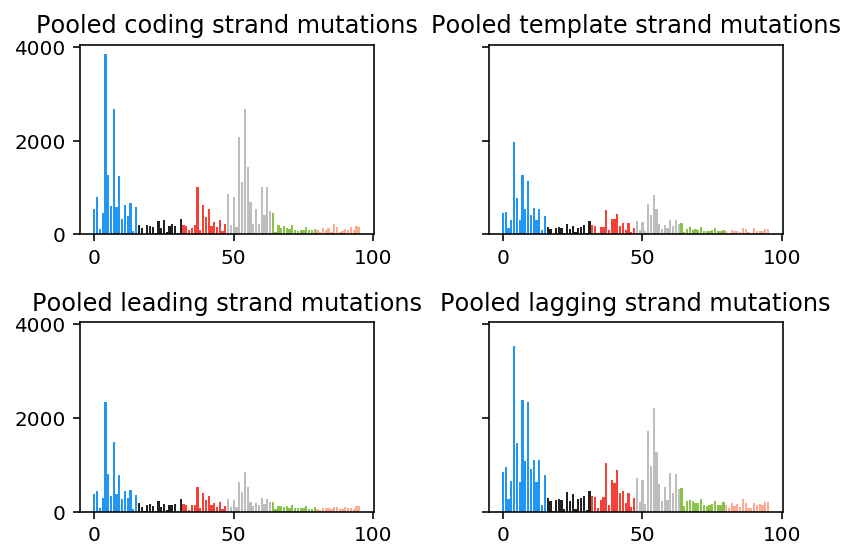

In [13]:
fig, axes = plt.subplots(2, 2, sharey=True)
axes[0, 0].bar(np.arange(96), coding, color=ts.DARK_PALETTE)
axes[0, 0].set_title("Pooled coding strand mutations")
axes[0, 1].bar(np.arange(96), template, color=ts.DARK_PALETTE)
axes[0, 1].set_title("Pooled template strand mutations")
axes[1, 0].bar(np.arange(96), leading, color=ts.DARK_PALETTE)
axes[1, 0].set_title("Pooled leading strand mutations")
axes[1, 1].bar(np.arange(96), lagging, color=ts.DARK_PALETTE)
axes[1, 1].set_title("Pooled lagging strand mutations")
plt.tight_layout()

which reveals that some variant types, e.g. C>A (blue), C>T (red) and T>A (grey), seem to occur with different frequencies across transcription and replication states.

By indexing the SNV tensor appropriately, we can also recover mutational spectra from different state combinations, eg. `snv[0,:,2].sum(axis=(0,1))` would return a $p \times n$ matrix representing the coding strand mutations in state 2 of the first additional genomic dimension.
